In [1]:
from lib.config import Config
from lib.data_set import Dataset
from lib.model import NNModel
from lib import utils

In [3]:
import ctypes
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as KL
from tensorflow.keras import models as KM
from tensorflow import keras
import tensorflow as tf

## File name read

In [6]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the data with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)
player = ctypes.windll.kernel32

ind = df2.iloc[1].isna()
files = np.concatenate([np.array(df.columns),np.array('normal/'+df2.columns[ind])])

## Configuration

In [7]:
# Override the base class of Config and Features for RNN_CNN Model
class RCNN_Config(Config):
    
    NAME = 'RNN_CNN'
    NUM_CLASSES = 2
    EPOCHS = 300
    BATCH_SIZE = 32
    COST_SENSITIVE = False
    CLASS_WEIGHTS = None
    TEST_FILES = files[[6,30,31,32,33,34,35]]
    
class Rect_dataset(Dataset):
    
    def __init__(self,config):
        super(Rect_dataset,self).__init__(config)
        self.n_env = config.N_ENV
    
    def rectify_data(self):
        
        self.Xr = utils.rectify_emg_moving_average(self.X,self.n_env)
        self.Xr2 = utils.rectify_emg_moving_average(self.X2,self.n_env)
        self.Xr3 = utils.rectify_emg_moving_average(self.X3,self.n_env)
    
    @property
    def train_set(self):
        return self.Xr,self.Y,self.F
    
    @property
    def valid_set(self):
        return self.Xr2,self.Y2,self.F2
    
    @property
    def test_set(self):
        return self.Xr3,self.Y3,self.F3

In [8]:
# Generate CWT-CNN configuration
config = RCNN_Config()
config.display()


Configurations:
BATCH_SIZE                     32
CHANNELS                       ['LEFT_TA', 'LEFT_TS', 'LEFT_BF', 'LEFT_RF', 'RIGHT_TA', 'RIGHT_TS', 'RIGHT_BF', 'RIGHT_RF']
CLASS_WEIGHTS                  None
COST_SENSITIVE                 False
DETREND_LAMBDA                 50
DROP_WITH_ZSCORE               None
EPOCHS                         300
FN_HP                          None
FN_IR                          False
FN_LP                          300
NAME                           RNN_CNN
NUM_CLASSES                    2
N_ENV                          20
RECT                           False
REMOVE_FREQS                   True
SAME_LABEL                     True
SCALE                          True
SHUFFLE                        True
STEP_SIZE                      512
TEST_FILES                     ['G08_FoG_1_trial_1_emg.csv' 'normal/G09_Walking_trial_2_emg.csv'
 'normal/G09_Walking_trial_4_emg.csv' 'normal/G09_Walking_trial_6_emg.csv'
 'normal/G11_Walking_trial_2_emg.csv' 'normal

## Data generate

In [9]:
data = Rect_dataset(config)

In [10]:
# Load data from files
data.load_data(files)

# Rectify the data to get envelope
data.rectify_data()

X_train,Y_train,_ = data.train_set
X_valid,Y_valid,_ = data.valid_set
X_test, Y_test, _ = data.test_set

skip
skip
3/174: G06_FoG_trial_1_emg.csv
4/174: G06_FoG_trial_2_emg.csv
5/174: G06_FoG_trial_3_emg.csv
6/174: G07_Freezing_Trial1_trial_1_emg.csv
7/174: G08_FoG_1_trial_1_emg.csv
8/174: G08_FoG_2_trial_1_emg.csv
9/174: G11_FoG_trial_1_emg.csv
10/174: G11_FoG_trial_2_emg.csv
11/174: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
12/174: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
13/174: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
14/174: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
15/174: P379_M050_2_OFF_B_FoG_trial_2_emg.csv
16/174: P379_M050_2_OFF_B_FoG_trial_3_emg.csv
17/174: P551_M050_2_A_FoG_trial_1_emg.csv
18/174: P551_M050_2_B_FoG_trial_1_emg.csv
19/174: P551_M050_2_B_FoG_trial_2_emg.csv
20/174: P812_M050_2_B_FoG_trial_1_emg.csv
21/174: P812_M050_2_B_FoG_trial_2_emg.csv
22/174: normal/G02_Walking_trial_1_emg.csv
23/174: normal/G03_Walking_trial_1_emg.csv
24/174: normal/G03_Walking_trial_2_emg.csv
25/174: normal/G05_Walking_struct_fixed_trial_1_emg.csv
26/174: normal/G05_Walking_struct_fixed_trial_2_emg.cs

171/174: normal/P940_MSham_A_Walking_trial_6_emg.csv
172/174: normal/P940_MSham_B_Walking_trial_2_emg.csv
173/174: normal/P940_MSham_B_Walking_trial_4_emg.csv
174/174: normal/P940_MSham_B_Walking_trial_6_emg.csv


## Model

In [46]:
# Override base class of SimpleMode for RNN_CNN
class RNN_CNN_Model(NNModel):
    
    def build(self, mode,config):
        self.input_shape = [config.WINDOW_SIZE, len(config.CHANNELS)]
        kernel_size=3
        reg=keras.regularizers.l2(1e-4)
        drop_rate = 0.
        kernel_initializer = 'glorot_normal'
        mo = 0.8
        st = 1
        axis = 2
        model = KM.Sequential()
        model.add(KL.InputLayer(input_shape=self.input_shape))

        model.add(KL.Bidirectional(KL.LSTM(32,return_sequences=True,
                                                   recurrent_regularizer=reg)))

        model.add(KL.Conv1D(filters=32, kernel_size=kernel_size,strides=st,
                                padding='same',
                                kernel_regularizer=reg,
                               ))
        model.add(KL.BatchNormalization(momentum=mo))

        model.add(KL.LeakyReLU(0.1))
        model.add(KL.MaxPooling1D(2))
        model.add(KL.Dropout(drop_rate))
        model.add(KL.Conv1D(filters=16, kernel_size=kernel_size,strides=st,
                                padding='same',
                                kernel_regularizer=reg,
                               ))
        model.add(KL.BatchNormalization(momentum=mo))

        model.add(KL.LeakyReLU(0.1))
        model.add(KL.MaxPooling1D(2))
        model.add(KL.Dropout(drop_rate))
        model.add(KL.Conv1D(filters=8, kernel_size=kernel_size,strides=st,
                                padding='same',
                                kernel_regularizer=reg,
                               ))
        model.add(KL.BatchNormalization(momentum=mo))

        model.add(KL.LeakyReLU(0.1))
        model.add(KL.MaxPooling1D(2))
        model.add(KL.Dropout(drop_rate))
        model.add(KL.Conv1D(filters=4, kernel_size=kernel_size,strides=st,
                                padding='same',
                                kernel_regularizer=reg,
                               ))
        model.add(KL.BatchNormalization(momentum=mo))

        model.add(KL.LeakyReLU(0.1))
        model.add(KL.MaxPooling1D(2))

        model.add(KL.GlobalAveragePooling1D())
        model.add(KL.Dropout(drop_rate))
        model.add(KL.Dense(config.NUM_CLASSES,activation='softmax',kernel_regularizer=reg))
        
        model.summary()
        if config.COST_SENSITIVE:
            self.cost_matrix = config.COST_MATRIX
            model.compile(loss=self.sparse_cost_sensitive_loss, optimizer="adam", metrics=['accuracy'])
            print('Using cost sensitive with cost matrix:\n',np.array(self.cost_matrix))
        else:
            model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
            if config.CLASS_WEIGHTS != None:
                print('Using categorical crossentropy with class weights:\n',config.CLASS_WEIGHTS)
            else:
                print('Using categorical crossentropy without class weights.')
        
        return model

    def sparse_cost_sensitive_loss (self,y_true,y_pred):
        cost_matrix = self.cost_matrix
        batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
        eps = 1e-6
        probability = tf.clip_by_value(y_pred, eps, 1-eps)
        cost_values = tf.math.log(1-probability)*batch_cost_matrix
        loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
        return loss

## Data split

In [ ]:
# data split and processing for model
class_id = [2,6]
binary = True
x_train,y_train,x_valid,y_valid,x_test,y_test = utils.data_split_oh((X_train,X_valid,X_test),
                                                                    (Y_train,Y_valid,Y_test),
                                                                    class_id,
                                                                    binary,
                                                                    random_state = 555)

## Model training

In [47]:
#cost_matrix = tf.constant([[0,1.5,1,1.2],
#              [1,0,1,1],
#              [5,10,0,5],
#              [1.,1.,1,0]])
#cost_matrix = tf.constant([[0.,1.,1.],
#              [10.,0.,1.],
#              [10.,4.,0.]])
config.COST_MATRIX = tf.constant([[0,1.],
              [10,0]])

if binary:
    config.COST_SENSITIVE = True
    config.NUM_CLASSES = 2
else:
    config.COST_SENSITIVE = False
    config.NUM_CLASSES = len(class_id)

rcnn_model = RNN_CNN_Model('RNN_CNN','training',config,'./model/RNN_CNN/')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 1024, 64)          10496     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1024, 32)          6176      
_________________________________________________________________
batch_normalization_24 (Batc (None, 1024, 32)          128       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 1024, 32)          0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 512, 32)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 512, 32)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 512, 16)         

In [48]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10,
                                             monitor = 'val_loss', 
                                             #baseline = 0.9,
                                             restore_best_weights=True)
rcnn_model.train((x_train,y_train),(x_valid,y_valid),config.EPOCHS,config.BATCH_SIZE,[early_stopping])


Starting at epoch 0.

Checkpoint Path: ./model/RNN_CNN/rnn_cnn20210117T0120\RNN_CNN_rnn_cnn_{epoch:04d}.h5
Epoch 1/300
15/15 [==============================] - 14s 630ms/step - loss: 0.6453 - accuracy: 0.6852 - val_loss: 0.7599 - val_accuracy: 0.2697
Epoch 2/300
15/15 [==============================] - 7s 454ms/step - loss: 0.5171 - accuracy: 0.8677 - val_loss: 0.4277 - val_accuracy: 0.9671
Epoch 3/300
15/15 [==============================] - 7s 454ms/step - loss: 0.4600 - accuracy: 0.9151 - val_loss: 0.4783 - val_accuracy: 0.9145
Epoch 4/300
15/15 [==============================] - 7s 448ms/step - loss: 0.4147 - accuracy: 0.9466 - val_loss: 0.4066 - val_accuracy: 0.9671
Epoch 5/300
15/15 [==============================] - 7s 454ms/step - loss: 0.3731 - accuracy: 0.9689 - val_loss: 0.3738 - val_accuracy: 0.9474
Epoch 6/300
15/15 [==============================] - 7s 477ms/step - loss: 0.3478 - accuracy: 0.9530 - val_loss: 0.3122 - val_accuracy: 0.9737
Epoch 7/300
15/15 [==============

## Model evaluation

In [52]:
acc_train,cm_train = rcnn_model.model_metrics(x_train,y_train)
acc_valid,cm_valid = rcnn_model.model_metrics(x_valid,y_valid)
acc_test,cm_test = rcnn_model.model_metrics(x_test,y_test)
print('acc_train: %f\nconfusion_matrix:\n'%acc_train,cm_train)
print('acc_valid: %f\nconfusion_matrix:\n'%acc_valid,cm_valid)
print('acc_test: %f\nconfusion_matrix:\n'%acc_test,cm_test)

acc_train: 0.982418
confusion_matrix:
 [[285   7]
 [  1 162]]
acc_valid: 0.980263
confusion_matrix:
 [[108   3]
 [  0  41]]
acc_test: 0.611650
confusion_matrix:
 [[ 8  1]
 [39 55]]


In [13]:
import matplotlib.pyplot as plt

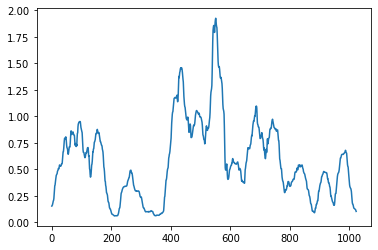

In [16]:
plt.plot(np.arange(1024),X_train[10,:,0])